In [1]:
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.compat.v2.keras import backend as K
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import ConfigProto, Session
config = ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(Session(config=config))
from tensorflow.compat.v1 import disable_eager_execution
disable_eager_execution()

## 准备数据

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2      ## 潜在空间维度

input_img = tf.keras.Input(shape=img_shape)

## 构筑模型

In [3]:
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)  #卷积核为3x3, 填充，步幅为（2,2）
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flatten = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def samplling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(samplling)([z_mean, z_log_var])

In [5]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flatten[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flatten[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = models.Model(decoder_input, x)

z_decoded = decoder(z)

In [6]:
class CustomVariantionalLayer(tf.keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1
        )
        return K.mean(xent_loss + kl_loss)
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariantionalLayer()([input_img, z_decoded])

In [7]:
from tensorflow.keras.datasets import mnist
vae = models.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
    shuffle=True,
    epochs=10,
    batch_size=batch_size,
    validation_data=(x_test, None)
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


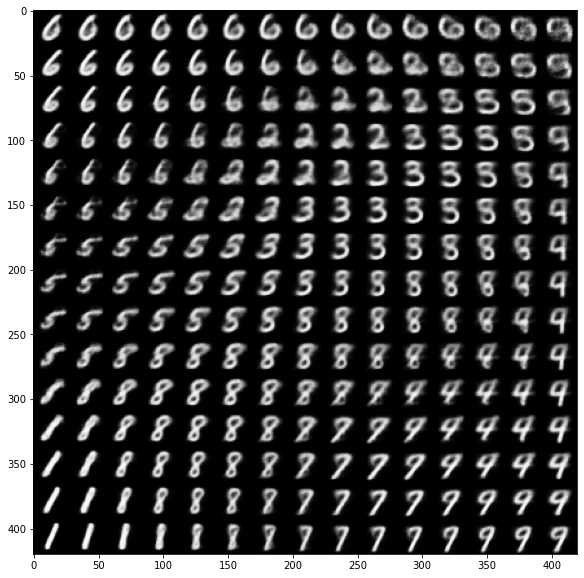

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i*digit_size: (i+1)*digit_size,
            j*digit_size: (j+1)*digit_size
        ] = digit
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()